<p style="font-size:50px;line-height:1em">
Set dataset
</p>

In [1]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
# import helper

transforms = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(112),
                                transforms.ToTensor()])

dataset = datasets.ImageFolder(root="/home/crypto/MS/lfw_funneled",
                           transform=transforms)
idx = torch.randperm(13233)
train_idx = torch.Tensor.tolist(idx[:10560])
test_idx = torch.Tensor.tolist(idx[10560:])

train_set = torch.utils.data.Subset(dataset, train_idx)
test_set = torch.utils.data.Subset(dataset, test_idx)

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=1024, num_workers = 8, shuffle =True)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=1024, num_workers = 8)

In [2]:
len(dataset) # 총 사진의 개수, train set 과 test set의 비율을 각각 0.8과 0.2로 설정하여 train index와 test index를 랜덤으로 분리함.

13233

In [3]:
dataset.__getitem__(13232)[1] #identity의 개수

5748

In [4]:
images, label = next(iter(train_dataloader))

<p style="font-size:50px;line-height:1em">
Visulaization of an input data

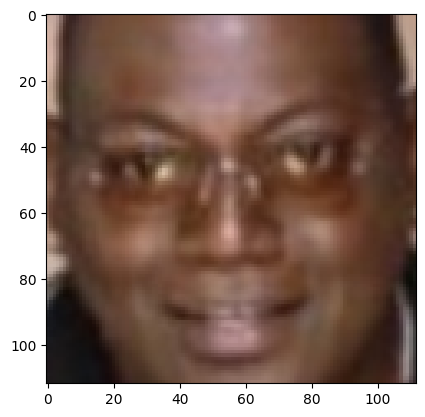

In [5]:
plt.imshow(images[0].permute(1,2,0))

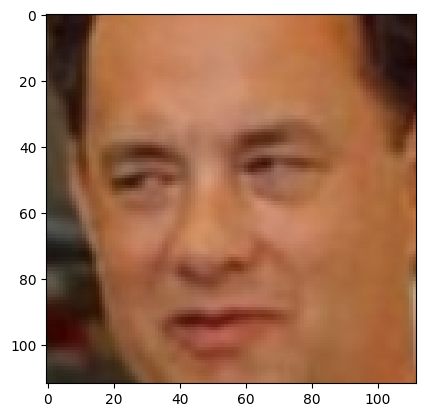

In [6]:
plt.imshow(images[1].permute(1,2,0))

<p style="font-size:50px;line-height:1em">
Set a model class

In [7]:
import torch
from torch import nn
import math
import torch.nn.functional as F

In [8]:
# Basic layers / Convolution, Activation, and Batch Normalization
def conv(ic,oc,k,s,p):
    return nn.Conv2d(ic,oc,k,s,p, bias = False)

# need to be checked
def act():
    return nn.ReLU()

def bn(ic):
    return nn.BatchNorm2d(ic, momentum = 0.1, affine = True)

In [9]:
# Convolution Block for Simplicity
class ConvBlock(nn.Module):
    def __init__(self,ic,oc,k,s,p):
        super(ConvBlock, self).__init__()
        self.model = nn.Sequential(
            conv(ic,oc,k,s,p),
            bn(oc)
        )
    
    def forward(self, x):
        return self.model(x)

In [10]:
class ResBlock(nn.Module):
    def __init__(self,
                in_channel,
                mid_channel,
                out_channel,
                downsample = False):
        super(ResBlock, self).__init__()
        
        self.downsample = downsample
        
        if downsample:
            mid_stride = 2
        else:
            mid_stride = 1
    
            

        self.model_main = nn.Sequential(
            ConvBlock(in_channel, mid_channel, 3, mid_stride, 1),
            act(),
            ConvBlock(mid_channel, out_channel, 3, 1, 1)

        )
        
        # Shortcut with 1x1 convolution // stride 2 convolution for downsampling
        if downsample:
            self.model_sc = ConvBlock(in_channel, out_channel, 1, mid_stride, 0)

    
    def forward(self, x):
        x_sc = x
        if self.downsample:
            x_sc = self.model_sc(x)
        x = self.model_main(x)
        
        return act()(x+x_sc)

In [11]:
class ResNet(nn.Module):
    def __init__(self,
                config, emb_size = 512):
        super(ResNet, self).__init__()
        self.init_channel = 64
        self.init_conv = ConvBlock(3,self.init_channel,7,1,3)
        
        self.layer, last_channel = self.get_layer(config)
        self.model = nn.Sequential(*self.layer)
        
        self.avgpool= nn.AvgPool2d(7,1)
        
        # BN -> FC -> BN
        self.last_fcn = nn.Sequential(
            nn.BatchNorm1d(last_channel),
            nn.Dropout(0.4),
            nn.Linear(last_channel, emb_size),
            nn.BatchNorm1d(emb_size)

        )
        
        
    # Helper function to construct each layers per stage
    def get_layer(self, config):
        layer = []
        layer_config = config
        ic = self.init_channel
        mc = ic
        oc = ic
        
        for layer_per_stage in layer_config:
            for idx in range(layer_per_stage):
                if idx==0:
                    downsample = True
                else:
                    downsample = False
                
                
                layer.append(ResBlock(ic,mc,oc,downsample))
                ic = oc

            mc *= 2

        return layer, oc
    
    def forward(self, x):
        x = act()(self.init_conv(x))
        x = self.model(x)
        x = self.avgpool(x)
        x = nn.Flatten()(x)
        
        x = self.last_fcn(x)
        
        return x

In [12]:
def get_resnet(num_layer, emb_size = 512):
    if num_layer == 18:
        config = [2,2,2,2, False]
    elif num_layer == 34:
        config = [3,4,6,3, False]
    else:
        raise ValueError("Not supported for %d layers, quitting..."%(num_layer))
    
    print("Consrturct ResNet with %d Layers..."%(num_layer))
    model = ResNet(config, emb_size)
    print("Done!")
    return model


# if __name__ == "__main__":
#     # Testing
#     import torchsummary
#     test_layers = [18,34]
    
    
#     for num_layer in test_layers:
#         model = get_resnet(num_layer)
#         print("Summary for %d layers..."%(num_layer))
#         torchsummary.summary(model, (3,112,112))

<p style="font-size:50px;line-height:1em">
Set a header 

In [13]:
import torch
from torch import nn
import torch.nn.functional as F
import math

class PlainHeader(nn.Module):
    def __init__(self, emb_size, num_classes, *args, **kwargs):
        super(PlainHeader, self).__init__()
        
        weight = torch.zeros(num_classes, emb_size)
        self.wt = nn.Parameter(nn.init.kaiming_normal_(weight))
        
    def forward(self, x, gt):
        return nn.CrossEntropyLoss()(F.linear(x, self.wt), gt)

class ArcFaceHeader(nn.Module):
    def __init__(self,emb_size, num_classes, scale=64, margin = 0.5, *args, **kwargs):
        super(ArcFaceHeader, self).__init__()
        weight = torch.zeros(num_classes, emb_size)
        self.wt = nn.Parameter(nn.init.kaiming_normal_(weight))
        self.scale = scale
        self.margin = margin
        self.num_classes = num_classes
        self.emb_size = emb_size
        
        self.cos_y = math.cos(margin)
        self.sin_y = math.sin(margin)
        
        self.y_siny = margin * self.sin_y
    
    def forward(self, x, gt):
       
        # Assume that gt: integer
        wt_norm = F.normalize(self.wt, dim=1)
        x_norm = F.normalize(x, dim=1)
        
        cos_score = F.linear(x_norm, wt_norm)
        gt_onehot = F.one_hot(gt, num_classes = self.num_classes)
        
        cos_x = torch.gather(cos_score, 1, gt.unsqueeze(-1)).clamp(0,1)
        sin_x = torch.sqrt(1.-torch.pow(cos_x, 2)).clamp(0,1)
        
        cos_xm = cos_x*self.cos_y - sin_x*self.sin_y
        #cos_xm_s = torch.where(cos_x>-self.cos_y, cos_xm, cos_x-self.y_siny)

        marginal_score = gt_onehot*(cos_xm-cos_x)+cos_score

        return nn.CrossEntropyLoss()(self.scale * marginal_score, gt)

In [14]:
def get_header(header_type, *args, **kwargs):
    header_dict = {
        "plain":PlainHeader,
        "arcface":ArcFaceHeader
    }
    
    try:
        header = header_dict[header_type]
        
    except:
        raise ValueError("Header {} does not implemented, quitting...".format(header_type))
    
    #try:
    header = header(**kwargs)
    return header

    #except:
    #raise ValueError("Invalid config, quitting...")

<p style="font-size:50px;line-height:1em">
Device choice

In [15]:
if torch.cuda.is_available():
    # Use gpu(0)
    torch.cuda.set_device(0)
    print("Gpu #%d activated..."%torch.cuda.current_device())
    device = torch.device('cuda')
else: device = torch.device('cpu')

Gpu #0 activated...


<p style="font-size:50px;line-height:1em">
Hyperparemeter management

In [16]:
# Dataset & Training Loop
img_shape = (3,112,112)
batch_size = 1024
epoch = 300

# margins for arcface/cosface
emb_size = 512
scale = 64
margin = 0.5

# Optimizer
lr_backbone = 0.01
lr_header = 0.01
weight_decay = 1e-3
beta1, beta2 = 0.9, 0.999

In [17]:
num_classes = dataset.__getitem__(13232)[1]
img_shape = (3,112,112)
train_num_imgs = 10560
#Test; use 10% of the total dataset.
#num_imgs =  50000
print("# of classes : ", num_classes)
print("Image shape : ", img_shape)
print("# of images : ", train_num_imgs)

# of classes :  5748
Image shape :  (3, 112, 112)
# of images :  10560


<p style="font-size:50px;line-height:1em">
Configuration for Backbone and Header

In [18]:
num_backbone_layer = 18
header_type = "arcface"

In [19]:
# Get Backbone and Header
import torchsummary
backbone = get_resnet(num_backbone_layer, emb_size)
header = get_header(header_type, emb_size=emb_size,
                    num_classes=num_classes,
                    scale=scale, margin=margin)

backbone.to(device).train()
header.to(device).train()

print("Summary for %d layers..."%(num_backbone_layer))
print(torchsummary.summary(backbone, (3,112,112), device = "cuda"))

Consrturct ResNet with 18 Layers...
Done!
Summary for 18 layers...
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
         ConvBlock-3         [-1, 64, 112, 112]               0
            Conv2d-4           [-1, 64, 56, 56]           4,096
       BatchNorm2d-5           [-1, 64, 56, 56]             128
         ConvBlock-6           [-1, 64, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          36,864
       BatchNorm2d-8           [-1, 64, 56, 56]             128
         ConvBlock-9           [-1, 64, 56, 56]               0
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11           [-1, 64, 56, 56]          36,864
      BatchNorm2d-12           [-1, 64, 56, 56]             128
        ConvBlock-13           [-1, 

In [20]:
# Feed parameters from RAM to GPU
backbone = backbone.to(device)
header = header.to(device)

<p style="font-size:50px;line-height:1em">
Optimizer

In [21]:
optim_type = 'sgd'

if optim_type == "sgd":
    optim_backbone = torch.optim.SGD(backbone.parameters(), lr = lr_backbone,
                                    momentum = 0.9, weight_decay = weight_decay)
    optim_header = torch.optim.SGD(header.parameters(), lr= lr_header,
                                  momentum = 0.9, weight_decay = weight_decay)

<p style="font-size:50px;line-height:1em">
Save Current Parameters

In [22]:
def save_model_parameters(model, name):
    dir_header = "./params/"
    torch.save(model.state_dict(), dir_header+name+'_params.pth')
    
    
def save_model(model, name):
    dir_header = "./params/"
    torch.save(model, dir_header+name+'_model.pth')

In [23]:
import time

In [24]:
def train(dataloader, epoch, backbone, header, 
          optim_header, optim_backbone, tag):
    size = len(dataloader.dataset)
    dir_prefix = "/params/"
    dir_suffix = ".pth"
    acc_track = [0] * epoch
    loss_track = [0] * epoch
    
    state = tag+"_started."
    logging('log.txt', state)
    
    for ech in range(epoch+1):
        tic_ech = time.time()
        tic_batch = time.time()
        
        cnt_ans = 0
        
        print("epoch {} begins".format(ech+1))
        print("Learning rate backbone: {}".format(optim_backbone.param_groups[0]['lr']))
        print("Learning rate header: {}".format(optim_header.param_groups[0]['lr']))
        
        for idx,(x,y) in enumerate(dataloader):
            x,y = x.to(device), y.to(device)
            
            # Forward_pass
            feature = backbone(x)
            loss = header(feature,y)

            # Backward_pass
            optim_header.zero_grad()
            optim_backbone.zero_grad()
            loss.backward()
            optim_header.step()
            optim_backbone.step()
            
                
        
        toc_ech = time.time()
        
        # Logging for each epoch
        print()
        print("epoch %d done."%(ech+1))
        print(f"loss: {loss:>7f}  [{train_num_imgs:>5d}/{train_num_imgs:>5d}]")
        print("time consumed : ", toc_ech-tic_ech)
        cnt = 0
        
        backbone.eval()
        header.eval()
        
        for i in iter(test_dataloader):
            cnt += (torch.argmax( backbone(i[0].to(device)) @ header.wt.T, axis = 1) == i[1].to(device)).sum()
        print('current accuracy: ', int(cnt/ len(test_set) * 100) , '%')
        print('-' * 40)
        
        backbone.train()
        header.train()
   
        
        if ech%10 ==0 and ech>0:
            save_model(backbone, header_type + "_"+tag+ "_backbone_%d"%(ech+1))
            save_model(header, header_type + "_"+tag+"_header_%d"%(ech+1))
        

In [25]:
# Logging
import datetime

def logging(name, state):
    curr_time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    f = open(name, 'a')
    f.write("[{}] ".format(curr_time)+ state+"\n")
    f.close()

In [26]:
# Tracking computed accuracy and loss
torch.backends.cudnn.enabled = True
train(train_dataloader, epoch, backbone, header, optim_header, optim_backbone, tag="arc_res18_sgd_0.01_step_do")

epoch 1 begins
Learning rate backbone: 0.01
Learning rate header: 0.01

epoch 1 done.
loss: 42.678391  [10560/10560]
time consumed :  6.793236255645752
current accuracy:  1 %
----------------------------------------
epoch 2 begins
Learning rate backbone: 0.01
Learning rate header: 0.01

epoch 2 done.
loss: 42.146049  [10560/10560]
time consumed :  5.4169533252716064
current accuracy:  0 %
----------------------------------------
epoch 3 begins
Learning rate backbone: 0.01
Learning rate header: 0.01

epoch 3 done.
loss: 40.961411  [10560/10560]
time consumed :  5.4014832973480225
current accuracy:  1 %
----------------------------------------
epoch 4 begins
Learning rate backbone: 0.01
Learning rate header: 0.01

epoch 4 done.
loss: 40.800495  [10560/10560]
time consumed :  5.360208749771118
current accuracy:  3 %
----------------------------------------
epoch 5 begins
Learning rate backbone: 0.01
Learning rate header: 0.01

epoch 5 done.
loss: 40.284229  [10560/10560]
time consumed :  

<p style="font-size:50px;line-height:1em">
Set a test algorithm

In [47]:
backbone = torch.load("./params/arcface_arc_res18_sgd_0.01_step_do_backbone_301_model.pth")
backbone.eval().to("cuda:0")
header = torch.load("./params/arcface_arc_res18_sgd_0.01_step_do_header_301_model.pth")
header.eval().to("cuda:0")

ArcFaceHeader()

In [48]:
backbone.eval()
header.eval()
cnt = 0
for i in iter(train_dataloader):
    Q = backbone(i[0].to(device)) @ header.wt.T
    cnt += (torch.argmax( Q , axis = 1) == i[1].to(device)).sum()
print('current accuracy: ', cnt/ len(train_set) * 100 , '%')

backbone.train()
header.train()

current accuracy:  tensor(100.0000, device='cuda:0') %


ArcFaceHeader()

In [49]:
backbone.eval()
header.eval()
cnt = 0
for i in iter(test_dataloader):
    Q = backbone(i[0].to(device)) @ header.wt.T
    cnt += (torch.argmax( Q , axis = 1) == i[1].to(device)).sum()
print('current accuracy: ', cnt/ len(test_set) * 100 , '%')

backbone.train()
header.train()

current accuracy:  tensor(14.6652, device='cuda:0') %


ArcFaceHeader()